<a href="https://colab.research.google.com/github/rja868/Clustering-Customers/blob/main/clustering-technique-cust-segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Customer Segmentation**
Richard Albanese

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

# Load the dataset
file_path = 'https://raw.githubusercontent.com/rja868/Clustering-Customers/main/Mall_Customers.csv'
data_mall = pd.read_csv(file_path)

# 1. Data Exploration and Analysis

In [4]:
data_mall.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [5]:
data_mall.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [6]:
# Get min and max values for Age, Annual Income and Spending Score

print(f"The range of ages is: {data_mall['Age'].min()} to {data_mall['Age'].max()}")
print(f"The range of Annual Income is: {data_mall['Annual Income (k$)'].min()} to {data_mall['Annual Income (k$)'].max()}")
print(f"The range of Spending Score is: {data_mall['Spending Score (1-100)'].min()} to {data_mall['Spending Score (1-100)'].max()}")

The range of ages is: 18 to 70
The range of Annual Income is: 15 to 137
The range of Spending Score is: 1 to 99


In [7]:
data_mall.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


Based on the above, we can see the data has 200 entries, with each entry representing a different customer.  There is a numerical index column, customerID (also numerical but starting at 1 whereas the index starts at 0), Gender (object), Age (ranges from 18 to 70, average is 39), Annual Income (ranges from \$15k to $137k, average is \$61k) and Spending Score (ranges from 1 to 99, average is 50).

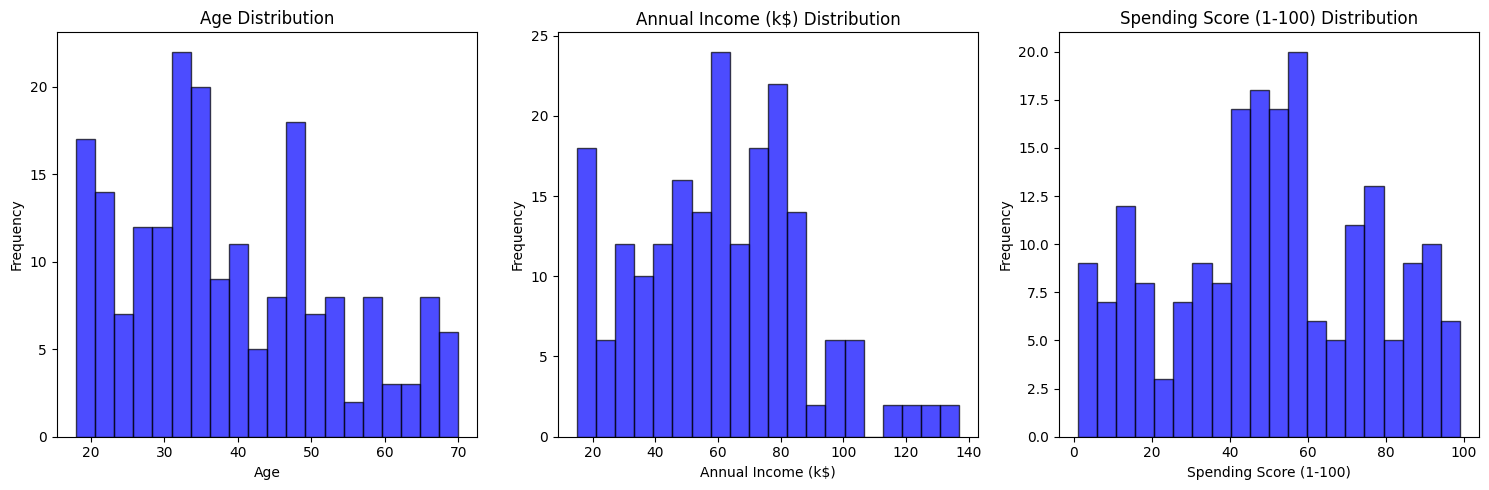

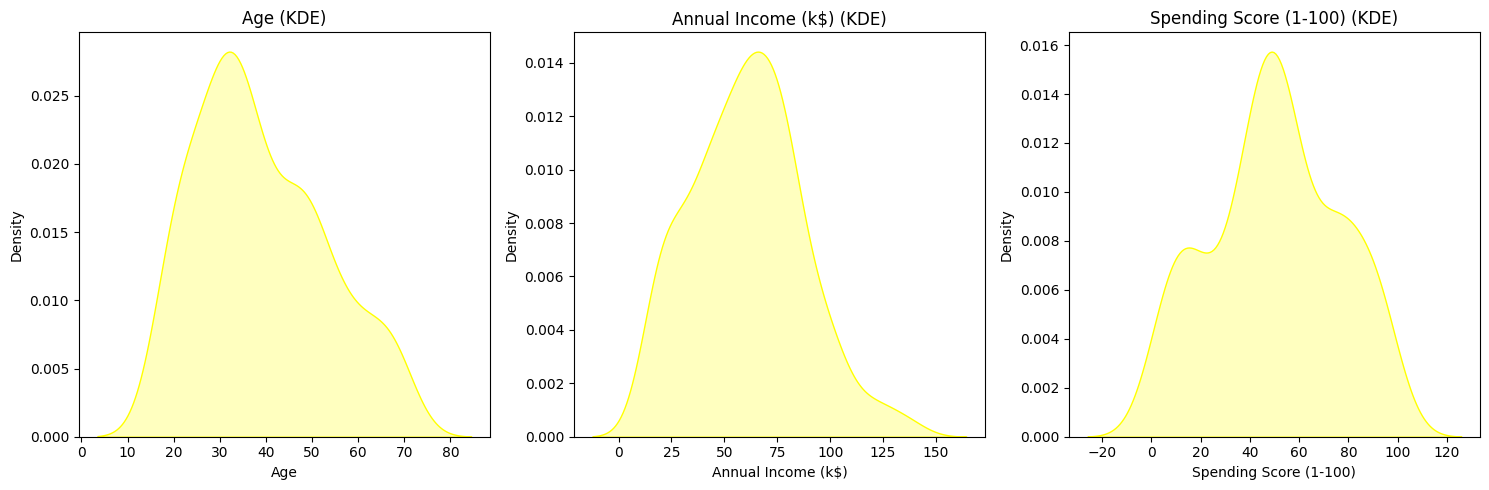

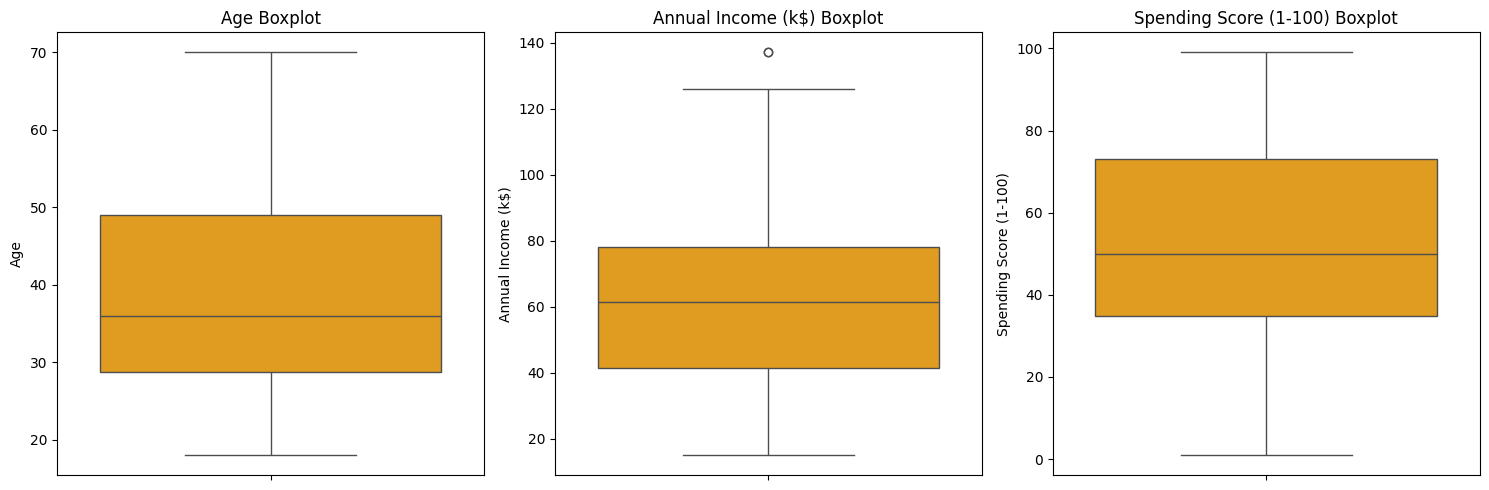

In [8]:
# Plot distribution of features
import seaborn as sns
from scipy.stats import skew

# List of features to plot
features = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)']

# Create histograms
plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    plt.hist(data_mall[feature], bins=20, alpha=0.7, color='blue', edgecolor='black')
    plt.title(f'{feature} Distribution')
    plt.xlabel(feature)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# Create Kernel Density Plots (KDE Plot)

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.kdeplot(data_mall[feature], fill=True, color='yellow')
    plt.title(f'{feature} (KDE)')
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# Create Boxplots

plt.figure(figsize=(15, 5))

for i, feature in enumerate(features):
    plt.subplot(1, len(features), i + 1)
    sns.boxplot(y=data_mall[feature], color='orange')
    plt.title(f'{feature} Boxplot')
    plt.ylabel(feature)

plt.tight_layout()
plt.show()


In [9]:
# Compute skewness of each variable
for i, feature in enumerate(features):
    skewness = skew(data_mall[feature])
    print(f"Skewness of {feature}: {skewness}")


Skewness of Age: 0.48191947090957177
Skewness of Annual Income (k$): 0.319423684276314
Skewness of Spending Score (1-100): -0.04686530945553505


In [10]:
# Detect outliers

# Calculate Q1, Q3, and IQR for each feature
outliers = pd.DataFrame()  # To store outliers
for feature in features:
    Q1 = data_mall[feature].quantile(0.25)
    Q3 = data_mall[feature].quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier thresholds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    feature_outliers = data_mall[(data_mall[feature] < lower_bound) | (data_mall[feature] > upper_bound)]
    outliers = pd.concat([outliers, feature_outliers])  # Append to the outliers DataFrame

print(outliers)
print(f'Upper bound: {upper_bound}')
print(f'Lower bound: {lower_bound}')


     CustomerID Gender  Age  Annual Income (k$)  Spending Score (1-100)
198         199   Male   32                 137                      18
199         200   Male   30                 137                      83
Upper bound: 130.375
Lower bound: -22.625


Based on the visualizations above, we can make the following observations and insights:

*   The age variable exhibits positive skewness (right-skewness), calculated as 0.48.  This is visible in both the Age histogram and KDE.  In the boxplot, the median line is closer to the "younger" side of the box, also indicating skewness in the data.  Annual Income and Spending Score are less skewed and closer to a normal distribution.
*   As shown in the boxplots, the middle 50% of Annual Income values is within a tighter range than the other two features.  The distributions for Age and Spending Score are more spread out.  The is also visible in the histograms and KDE plots.
*   In terms of outliers, there are two rows with a value 137 for Annual Income, which are technically outliers based on the IQR method.  However the deviation from the range of data is mild and will not have a heavy influence of our analysis.  Plus, \$137k is a realistic value for our population so we will *not* label these outliers and will include them in our analysis.



# 2. Enhanced Clustering with K-Means

Apply K-Means Clustering to the Standardized Data:

In [11]:
# Select relevant features for clustering
selected_features = data_mall[['Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
scaled_data_mall = scaler.fit_transform(selected_features)

# Apply KMeans clustering with 5 clusters
num_clusters = 5  # This can be adjusted based on experimentation
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_mall['Cluster'] = kmeans.fit_predict(scaled_data_mall)

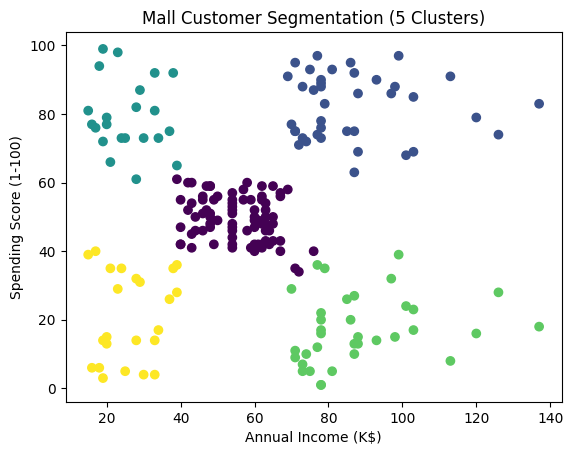

In [12]:
# Scatter Plot for Initial K-Means Clustering (5 clusters)
plt.scatter(data_mall['Annual Income (k$)'], data_mall['Spending Score (1-100)'], c=data_mall['Cluster'], cmap='viridis')
plt.title('Mall Customer Segmentation (5 Clusters)')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

Before applying the Elbow Method and Silhouette Score, let's use a different number of clusters and compare the results.

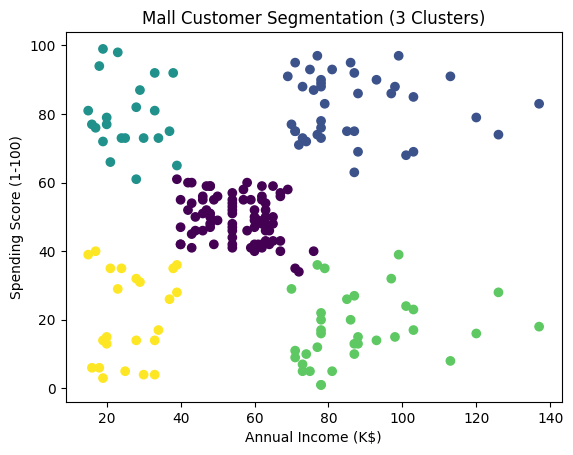

In [13]:
# Apply KMeans clustering with 3 clusters
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_mall['Cluster_3'] = kmeans.fit_predict(scaled_data_mall)

# Scatter Plot for Initial K-Means Clustering (5 clusters)
plt.scatter(data_mall['Annual Income (k$)'], data_mall['Spending Score (1-100)'], c=data_mall['Cluster'], cmap='viridis')
plt.title('Mall Customer Segmentation (3 Clusters)')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

By reducing the clusters from 5 to 3, we can see that two of the clusters are nearly identical to the 5-cluster results (the upper right cluster that represents high-income/high-spending and the bottom right cluster that represents high-income/lower-spending).  However, the other three distinct clusters we saw in the 5-cluster segmentation have now been combined into one (yellow).

If we ignore the colors in this scatter plot, it appears this large cluster that formerly consisted of three clusters has been inappropriately combined because we can see three distinct grouping inside of it.  This is a non-scientific observation but the scatter plot does portray five distinct groups, which leads us to believe the three cluster iteration is not optimal.

Let's try 7 clusters:

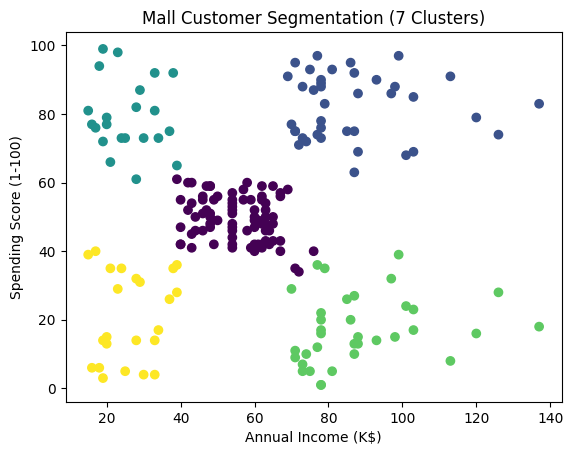

In [14]:
# Apply KMeans clustering with 7 clusters
num_clusters = 7
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
data_mall['Cluster_7'] = kmeans.fit_predict(scaled_data_mall)

# Scatter Plot for Initial K-Means Clustering (5 clusters)
plt.scatter(data_mall['Annual Income (k$)'], data_mall['Spending Score (1-100)'], c=data_mall['Cluster'], cmap='viridis')
plt.title('Mall Customer Segmentation (7 Clusters)')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.show()

If we compare this 7-cluster plot to the original 5-cluster plot, we can see that the lower left cluster (representing low-income/low-spending) and the upper right cluster (representing high-income/high-spending) have been split into two clusters each.  In effect, there is now an extreme high-income/high-spend group in the far upper right and an extreme low-income/low-spend group in the very left corner of the plot.

Compared to the five-cluster plot, we see there are a few customers shifting from cluster to cluster but for the most part, the clusters defined in the initial 5-cluster model have held up.  For example, there were only three customers added to the central cluster (mid-income, mid-spend) when we moved from the 5-cluster model to the 7.

Also, the two additional groupings created with the 7-cluster model do not seem as visually well-defined as the 5-cluster model.  In the 5-cluster model, there is pronounced white space between each cluster, whereas the new clusters in the 7-cluster plot have less white space around them.

Based on our non-scientific approach, it appears 5 clusters is optimal because the 3-cluster plot shows a large grouping that could easily contain three distinct groups while the 7-cluster model provides two new groups but they aren't visually well-defined.

Let's apply the Elbow Method to determine the optimal number of clusters:

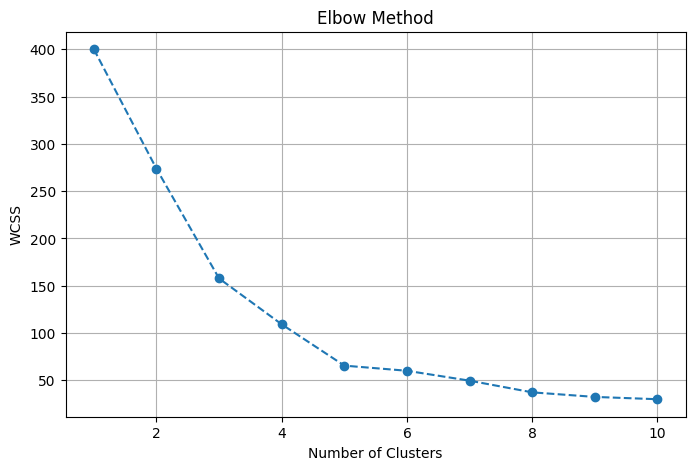

In [15]:
# Elbow Method
wcss = []

# Compute WCSS for different number of clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_mall)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In the above plot, we can see how WCSS (within-cluster sum of squares) changes as the number of clusters in the model increases.  Essentially, WCSS measures the compactness of the clusters.  The optimal number of clusters is the point in the curve where the WCSS value decreases at a much slower rate, flattening out the curve.

Above, we can see dramatic decreases in WCSS from 1 to 2 clusters, then from 2 to 3, 3 to 4 and 4 to 5.  But when we move from 5 to 6, the decrease in WCSS is much less than the decrease in WCSS when we moved from 4 to 5.  So, it appears 5 clusters is optimal when applying the Elbow Method.

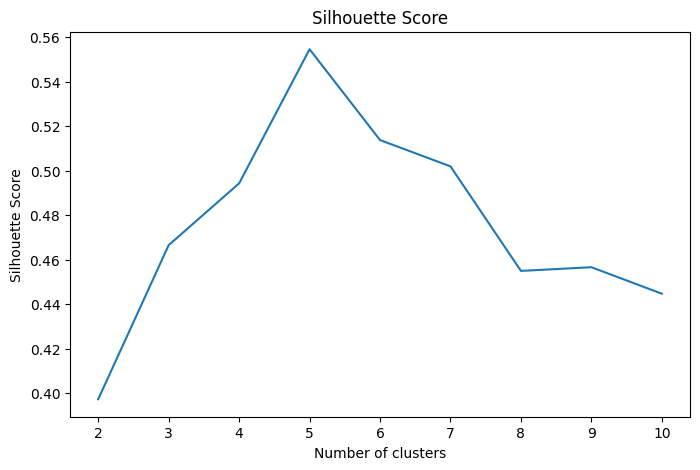

In [16]:
# Silhouette Score
from sklearn.metrics import silhouette_score

silhouette_scores = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_mall)
    score = silhouette_score(scaled_data_mall, kmeans.labels_)
    silhouette_scores.append(score)

plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores)
plt.title('Silhouette Score')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


The above plot shows us the Silhouette Score for each number of clusters.  This score measure the similarity between each point and its assigned cluster. So, a higher silhouette score indicates better-defined clusters.

This method also indicates that 5 clusters is optimal.

# 3. Hierarchical Clustering

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

# Hierarchical Clustering using 'ward' which minimizes the variance between clusters
Z = linkage(scaled_data_mall, 'ward')


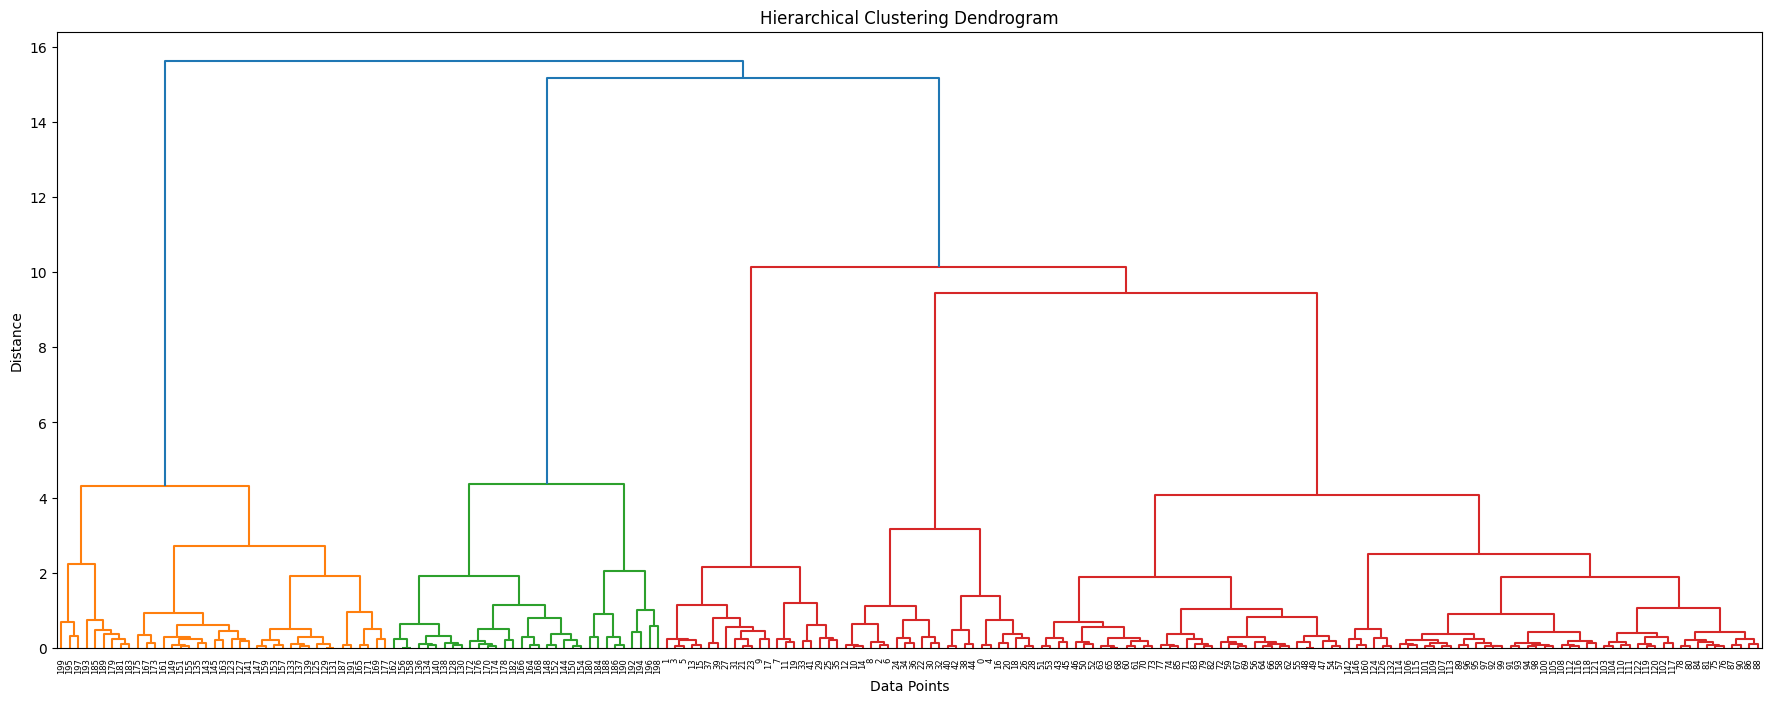

In [18]:
# Visualize with a Dendrogram
plt.figure(figsize=(22, 8))  # Width increased so we can see index numbers on x-axis
dendrogram(Z, labels=data_mall.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.xticks(rotation=90, fontsize = 6) # Rotate x-axis labels and set text size
plt.show()


Analyze the dendrogram to determine the optimal number of clusters:

By using the Longest Vertical Distance (or Horizontal Cuts) method, five is determined as the optimal number of clusters.  This method is performed by drawing a horizontal line across the entire dendrogram just below the largest vertical gap.  Then, we count the number of vertical lines intersecting the horizontal line.

We can use the *fcluster* function to create flat clusters:

In [19]:
from scipy.cluster.hierarchy import fcluster

# Set the number of clusters (based on dendrogram as outlined above)
num_clusters = 5
cluster_labels = fcluster(Z, t=num_clusters, criterion='maxclust')
data_mall['Cluster_HC'] = cluster_labels  # Create column of cluster label for the HC model

# Display rows with cluster labels
print(data_mall[['Annual Income (k$)', 'Spending Score (1-100)', 'Cluster_HC']])


     Annual Income (k$)  Spending Score (1-100)  Cluster_HC
0                    15                      39           4
1                    15                      81           3
2                    16                       6           4
3                    16                      77           3
4                    17                      40           4
..                  ...                     ...         ...
195                 120                      79           1
196                 126                      28           2
197                 126                      74           1
198                 137                      18           2
199                 137                      83           1

[200 rows x 3 columns]


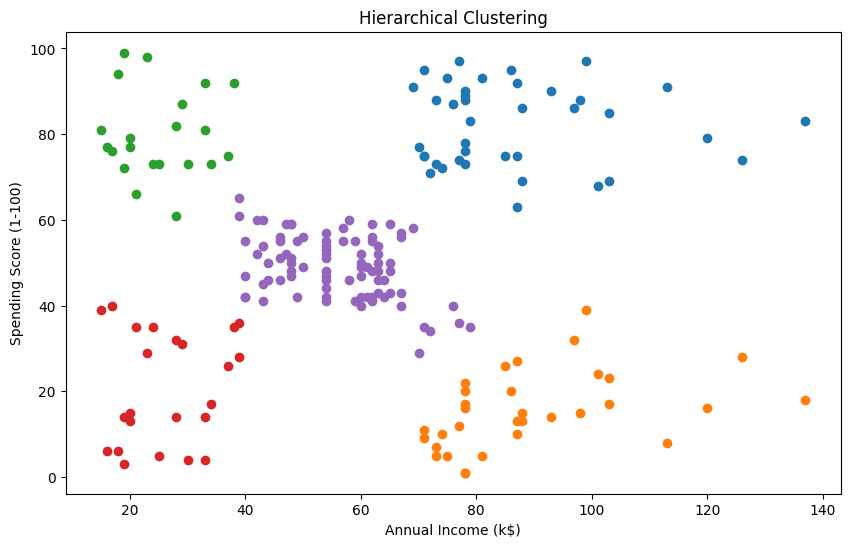

In [20]:
# Scatter plot of the clusters
plt.figure(figsize=(10, 6))
for cluster in np.unique(data_mall['Cluster_HC']):
    plt.scatter(
        data_mall[data_mall['Cluster_HC'] == cluster]['Annual Income (k$)'],
        data_mall[data_mall['Cluster_HC'] == cluster]['Spending Score (1-100)'],
    )
plt.title('Hierarchical Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.show()


Let's compare this Hierarchical Clustering (5 clusters) plot with the initial 5-cluster K-Means plot from earlier:

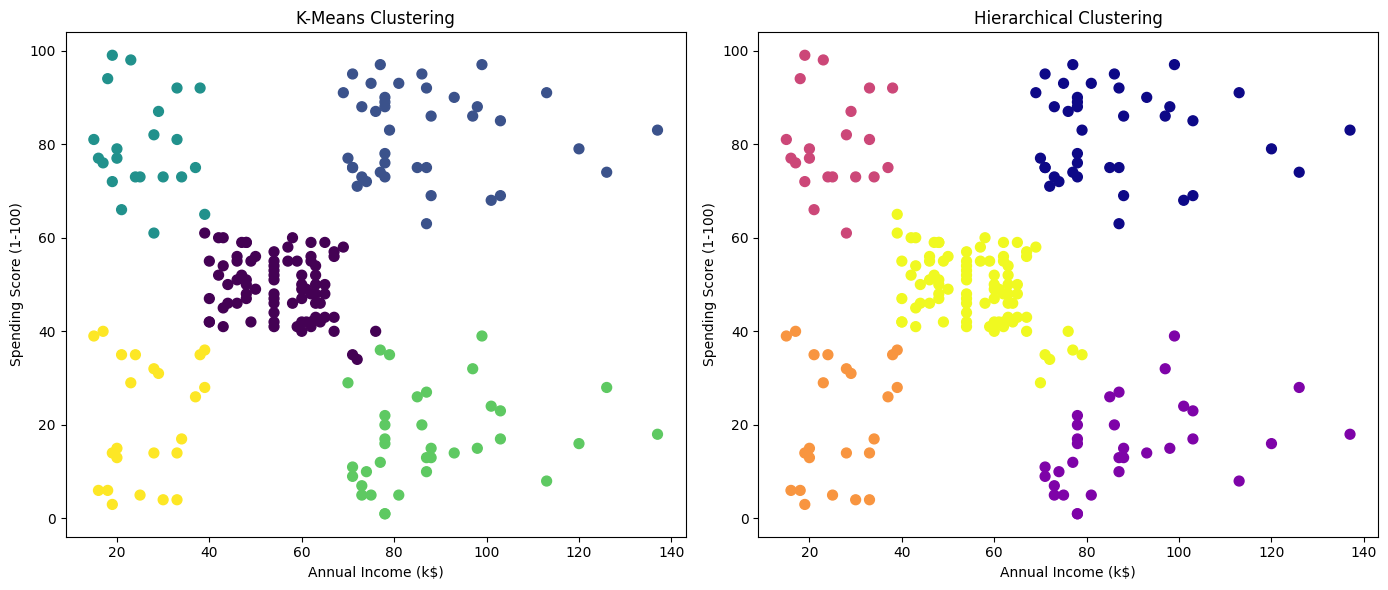

In [21]:
# Compare K-Means and Hierarchical clustering results
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(
    data_mall['Annual Income (k$)'],
    data_mall['Spending Score (1-100)'],
    c=data_mall['Cluster'], cmap='viridis', s=50
)
plt.title('K-Means Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.subplot(1, 2, 2)
plt.scatter(
    data_mall['Annual Income (k$)'],
    data_mall['Spending Score (1-100)'],
    c=data_mall['Cluster_HC'], cmap='plasma', s=50
)
plt.title('Hierarchical Clustering')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')

plt.tight_layout()
plt.show()


The two models exhibit similar clusters.  When the Hierarchical model is used, the middle cluster (mid-spending, mid-income) grew slightly, adding a few customers from surrounding clusters.  But overall, changing models from K-means to Hierarchical Clustering resulted in similar results.

If we change the number of clusters in the Hierarchical Clustering model to 3, the results are similar, with the scatter plot looking very similiar to the 3-cluster K-means scatter plot we created earlier.

The slight differences in clustering can be explained by differences in clustering approaches.  K-Means is partition-based and starts by randomly initializing the cluster centroids.  Then assigns data points to the nearest centroid.  The process repeats in order minimize the variance within each cluster.

Hierachical Clustering takes a different approach by building a tree by repeatedly merging or splitting clusters based on distances.  Unlike K-Means, HC does not rely on random initialization.

One other difference is that K-Means assumes spherical clusters while HC handles irregular shapes.

# 4. Comprehensive Cluster Analysis

In [22]:
# Display a few rows comparing the cluster assignments
print(data_mall[['Annual Income (k$)', 'Spending Score (1-100)', 'Cluster', 'Cluster_HC']])


     Annual Income (k$)  Spending Score (1-100)  Cluster  Cluster_HC
0                    15                      39        4           4
1                    15                      81        2           3
2                    16                       6        4           4
3                    16                      77        2           3
4                    17                      40        4           4
..                  ...                     ...      ...         ...
195                 120                      79        1           1
196                 126                      28        3           2
197                 126                      74        1           1
198                 137                      18        3           2
199                 137                      83        1           1

[200 rows x 4 columns]


In [23]:
# Compare the number of points in each cluster
print("K-Means Cluster Counts:")
print(data_mall['Cluster'].value_counts())

print("\nHierarchical Cluster Counts:")
print(data_mall['Cluster_HC'].value_counts())


K-Means Cluster Counts:
Cluster
0    81
1    39
3    35
4    23
2    22
Name: count, dtype: int64

Hierarchical Cluster Counts:
Cluster_HC
5    85
1    39
2    32
4    23
3    21
Name: count, dtype: int64


In [24]:
# Remap the HC cluster labels to ensure consistency across both sets of cluster labels

label_mapping_for_HC = {5:0, 1:1, 2:3, 4:4, 3:2}
data_mall['HC_Cluster_Re-numbered'] = data_mall['Cluster_HC'].map(label_mapping_for_HC)

# Check the updated labels
print(data_mall[['Cluster_HC', 'HC_Cluster_Re-numbered']])


     Cluster_HC  HC_Cluster_Re-numbered
0             4                       4
1             3                       2
2             4                       4
3             3                       2
4             4                       4
..          ...                     ...
195           1                       1
196           2                       3
197           1                       1
198           2                       3
199           1                       1

[200 rows x 2 columns]


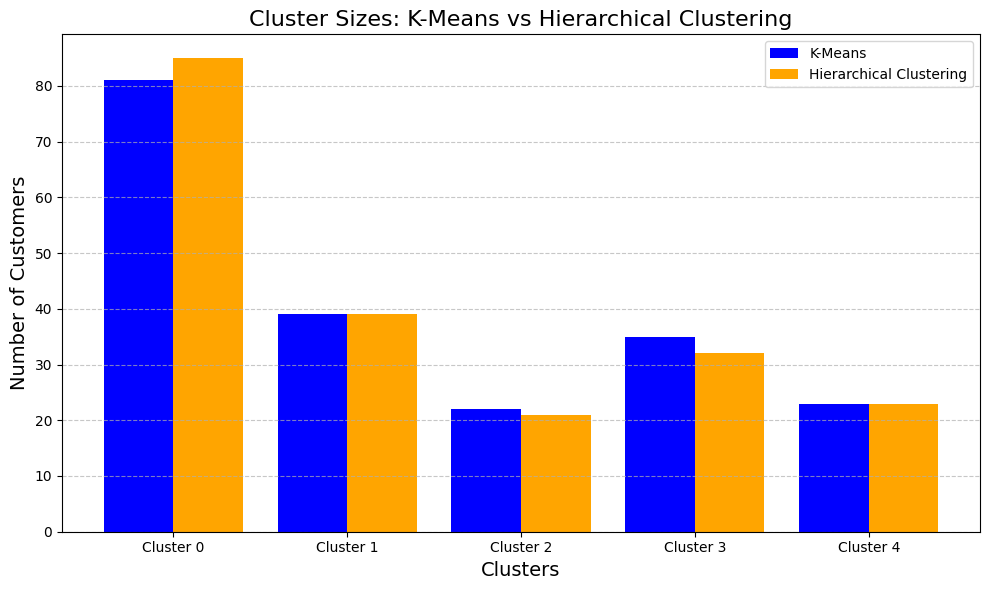

In [25]:
# Histogram to show diffences in clustering counts

# Cluster counts for K-Means and HC
kmeans_counts = data_mall['Cluster'].value_counts().sort_index()
hc_counts = data_mall['HC_Cluster_Re-numbered'].value_counts().sort_index()

# Ensure the clusters align in order for both methods
kmeans_counts = kmeans_counts.sort_index()
hc_counts = hc_counts.sort_index()

# Create a grouped bar chart
x = np.arange(len(kmeans_counts))  # Cluster indices
width = 0.4  # Bar width

plt.figure(figsize=(10, 6))

# K-Means bars
plt.bar(x - width / 2, kmeans_counts, width, label='K-Means', color='blue')

# HC bars
plt.bar(x + width / 2, hc_counts, width, label='Hierarchical Clustering', color='orange')

# Chart labels and legend
plt.title('Cluster Sizes: K-Means vs Hierarchical Clustering', fontsize=16)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(x, [f"Cluster {i}" for i in kmeans_counts.index])  # Custom x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


We can see from the above histogram that Cluster 1 and Cluster 4 have the same number of customers across both models while the others differ slightly in the number of customers assigned.

In [26]:
# Use Adjusted Rand Index (ARI) to measure the similarity between the two sets of clustering results:

from sklearn.metrics import adjusted_rand_score

ari_score = adjusted_rand_score(data_mall['Cluster'], data_mall['Cluster_HC'])
print(f"Adjusted Rand Index (ARI): {ari_score}")


Adjusted Rand Index (ARI): 0.9419606318143182


An ARI of 0.94 indicated the two sets of results are mostly in agreement.  A score of 1 would indicate perfect agreement.

Let's use the Silhouette analysis to identify the optimal number of clusters for HC:

In [27]:
from sklearn.metrics import silhouette_samples

# Compute the overall silhouette score for HC
silhouette_avg_HC = silhouette_score(scaled_data_mall, cluster_labels)
print(f"Average Silhouette Score for HC: {silhouette_avg_HC:.2f}")

# Compute the overall silhouette score for K-Means
silhouette_avg_Kmeans = silhouette_score(scaled_data_mall, data_mall['Cluster'])
print(f"Average Silhouette Score for K-Means: {silhouette_avg_Kmeans:.2f}")

Average Silhouette Score for HC: 0.55
Average Silhouette Score for K-Means: 0.55


The Silhouette scores for both models are the same at 0.55.  This indicates that the quality of clustering is similar.  A score 0.55 represents good clustering with some clusters being notably less compact than others.

As an additional measure of cluster quality, let's apply the Davies-Bouldin Index metric which measures the average similarity ratio between clusters:

In [28]:
from sklearn.metrics import davies_bouldin_score

db_index_HC = davies_bouldin_score(scaled_data_mall, cluster_labels)
print(f"Davies-Bouldin Index for HC: {db_index_HC}")

db_index_HC = davies_bouldin_score(scaled_data_mall, data_mall['Cluster'])
print(f"Davies-Bouldin Index for Kmeans: {db_index_HC}")


Davies-Bouldin Index for HC: 0.5778621190740154
Davies-Bouldin Index for Kmeans: 0.5722356162263352


According to the Davies-Bouldin index metric, our K-Means model performs slightly better than the HC model.  This indicates that the K-Means model has more compact and well-separated clusters, although the difference appears minimal.

Next, let's use Calinski-Harabasz Index to evaluate the quality of clustering between the two models.  This metric measures the ratio of between-cluster variance relative to within-cluster variance.  Between cluster variance should be greater than within-cluster variance, so a higher score indicates better-defined clusters.

In [29]:
from sklearn.metrics import calinski_harabasz_score

ch_index_HC = calinski_harabasz_score(scaled_data_mall, cluster_labels)
print(f"Calinski-Harabasz Index for HC: {ch_index_HC}")

ch_index_Kmeans = calinski_harabasz_score(scaled_data_mall, data_mall['Cluster'])
print(f"Calinski-Harabasz Index for K-Means: {ch_index_Kmeans}")

Calinski-Harabasz Index for HC: 244.41032586596822
Calinski-Harabasz Index for K-Means: 248.64932001536357


Again, our K-Means appears to have higher quality clusters than our HC model but the scores are fairly close.

Based on the quality of cluster measurements used above, it appears our K-Means model does have a slight edge over the HC model but overall, the quality of clustering across both model is very similar.

# 5. Reporting and Visualization


---
\

## **Executive Summary**

We are tasked with segmenting a anonymized population of 200 bank customers from a branch in a shopping mall.  Our data includes age, gender, income and spending level but we will focus on income and spending as features best suited for this project.  Our findings may be used for targeted marketing campaigns, product customization and customer experience improvements.  

In order to effectively group these customers by similarity we employed two clustering methodologies - K-Means and Hierarchical Clustering.  These clustering algorithms use very different processes for optimal clustering so its critical that we assess performance by applying various measures to assess cluster quality.

By using the available data, our goal is to segment this population of customers into distinct groups where the customers in each cluster are similar to each other and significantly different from customers found in other clusters.  Properly segmented customer groups should make our marketing, product development and customer experience initiatives more effective.

Of the models we evaluated, our K-Means clustering model generated the highest quality clusters.  Although the Hierarchical Clustering model also performed well, our evaluation metrics slightly favored the K-Means model in terms of highly differentiated customer groups.

Regardless of the model we used, five distinct customer groups (or clusters) were established:


*   High-income / High-spenders
*   High-income / Low-spenders
*   Mid-income / Mid-spenders
*   Low-income / Low-spenders
*   Low-income / High-spenders

The following scatter plot displays all data points, clustered by color and corresponding to the five groups above:

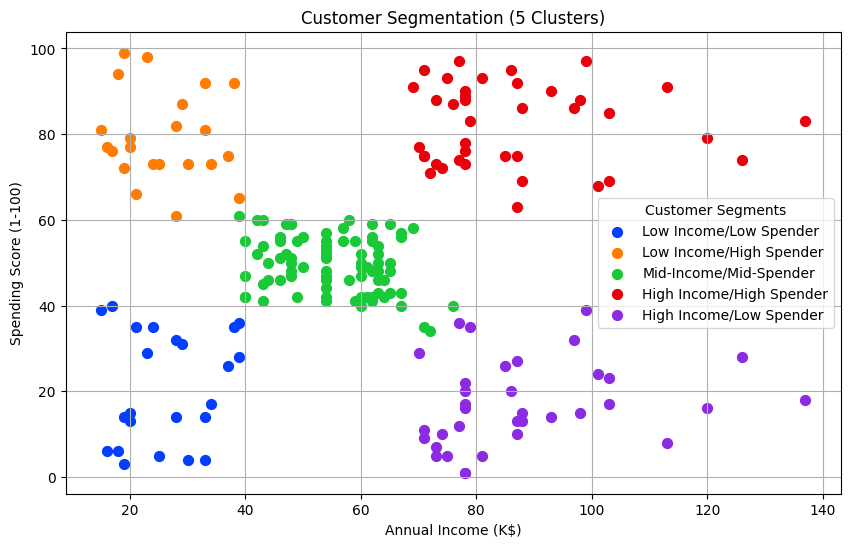

In [30]:
import seaborn as sns

# Define custom cluster names
cluster_names = {
    0: 'Mid-Income/Mid-Spender',
    1: 'High Income/High Spender',
    2: 'Low Income/High Spender',
    3: 'High Income/Low Spender',
    4: 'Low Income/Low Spender'
}

# Define a color palette for clusters
palette = sns.color_palette('bright', n_colors=len(data_mall['Cluster'].unique()))

# Plot with manual color mapping and custom cluster names
plt.figure(figsize=(10, 6))
for i, cluster in enumerate(data_mall['Cluster'].unique()):
    subset = data_mall[data_mall['Cluster'] == cluster]
    plt.scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'],
                color=palette[i], label=cluster_names[cluster], s=50)

# Add legend with custom labels
plt.legend(title='Customer Segments')
plt.title('Customer Segmentation (5 Clusters)')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()


There are various real-world applications for these customer groups, which will be discussed in the Business Applications section below.

---
\
## **Introduction**

Our dataset consists of 200 randomly selected customers with the following characteristics:  Gender, Age, Annual Income and Spending Score.  In the context of improved marketing, better product customization and enhanced user experiences, this data should prove useful.

Our task is to understand our customers' financial profiles in such as way that enables us to separate them into distinct groups or "clusters" which will ultimately be used for improving the business initiatives discussed above. The characteristics of customers appearing in the same cluster should be similar while customers that appear in different clusters should be significantly different from one another.

Ideally, a  version of this clustering model could be applied to considerably larger customer datasets in the future, assuming proper evaluation and testing has been performed.


---
\
## **Data Preparation and Methodology**

Preprocessing our data involved choosing key features (income, spending) and scaling these features for use in our model.  Then we transformed the data back to non-scaled in order to generate meaningful visualizations with properly label axis.  Our initial dataset did not contain any missing or duplicate values so cleaning the data was not required.

There were two data points considered outliers based on the IQR method. However the deviation from the range of data is mild and will not have a significant influence of our analysis. Plus, $137k is a realistic value for our population so we did not label these outliers and included them in our analysis.

In order to achieve optimal customer segmentation clusters, we applied two clustering techniques:


*   **K-Means** - Groups data into distinct clusters using feature similarity.  Center points (or "centroids") are initialized randomly, data points are assigned to the nearest centroid based on Euclidean distance, then centroids are recalculated until stable.

*   **Hierarchical Clustering** - Builds a hierarchy of clusters in a tree-like structure.  We used bottom-up or "Agglomerative Clustering" which starts with each data point as its own cluster and then applies a linkage strategy to create clusters.

Both techniques are examples of unsupervised machine learning, where customer groups are unknown in the initial data.  The algorithm identifies hidden patterns or relationships in the data which are then used to cluster the data points appropriately.

\

To determine the optimal number of clusters, we used the following methods:

*   **Elbow Method** - Used to choose the optimal number of clusters in our K-Means model by calculating the WCSS (within-cluster sum of squares) for each quantity of clusters (in this case, 1 through 10 clusters were evaluated).  WCSS measures the compactness of clusters.  When visualized as a line chart (pictured below) with WCSS on the y-axis and number of clusters on the x-axis, the optimal number of clusters is the point in the curve where the WCSS decrease slows down significantly. By using this technique, 5 clusters was determined to be the optimal number of clusters for our K-Means clustering model.  

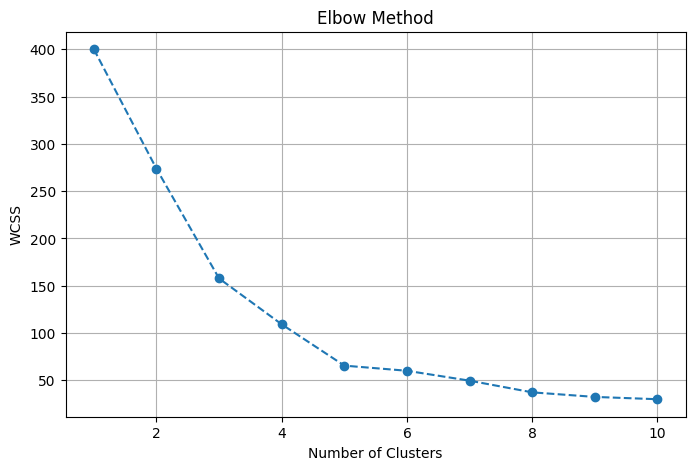

In [31]:
# Elbow Method
wcss = []

# Compute WCSS for different number of clusters
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(scaled_data_mall)
    wcss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()



*   **Longest Vertical Distance (Horizontal Cuts)** - This method was used to determine the optimal number of clusters for our HC model. It is performed by drawing a horizontal line across the entire dendrogram just below the largest vertical gap. Then, we count the number of vertical lines intersecting the horizontal line.  We determined five clusters to be optimal.

\

To evaluate the quality of clusters produced by these models, we used the following metrics:

*   **Silhouette Score** - This score measure the similarity between each point and its assigned cluster. So, a higher silhouette score indicates better-defined clusters.  This method also indicated that 5 clusters is optimal for our K-Means Model.  We also used Silhouette Score for comparing cluster quality across both models and found both had a Silhouette Score of 0.55, which indicates good clustering but some clusters being notably less compact than others.

*   **Davies-Bouldin Index** - This is another measure of cluster quality which measures the average similarity ratio between clusters.  Our K-Means model performed slightly better than the HC model according to this metric but the difference was minimal.

*   **Calinksi-Harabasz** - This metric measure the ratio of between-cluster variance relative to within-cluster variance.  The variance between clusters should be greater than the variance within clusters, so a higher score indicates better defined clusters.  Again, our K-Means model appears to have higher quality clusters but the score are fairly close.

\
We also used **Adjusted Rand Index (ARI)** to measure the similarity between the two sets of clustering results (K-Means and Hierarchical Clustering).  The ARI of 0.94 tells us the results are very similar.  This was also visualized in the following histogram which compares the number of customers placed in each cluster.



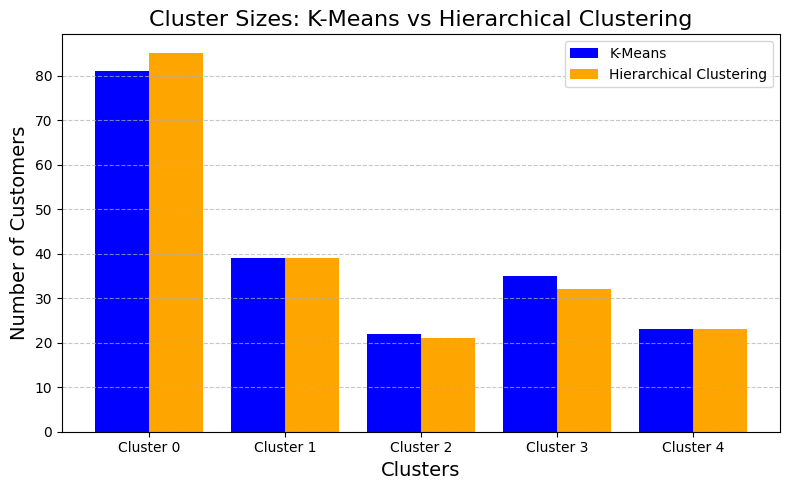

In [32]:
# Histogram to show diffences in clustering counts

# Cluster counts for K-Means and HC
kmeans_counts = data_mall['Cluster'].value_counts().sort_index()
hc_counts = data_mall['HC_Cluster_Re-numbered'].value_counts().sort_index()

# Ensure the clusters align in order for both methods
kmeans_counts = kmeans_counts.sort_index()
hc_counts = hc_counts.sort_index()

# Create a grouped bar chart
x = np.arange(len(kmeans_counts))  # Cluster indices
width = 0.4  # Bar width

plt.figure(figsize=(8, 5))

# K-Means bars
plt.bar(x - width / 2, kmeans_counts, width, label='K-Means', color='blue')

# HC bars
plt.bar(x + width / 2, hc_counts, width, label='Hierarchical Clustering', color='orange')

# Chart labels and legend
plt.title('Cluster Sizes: K-Means vs Hierarchical Clustering', fontsize=16)
plt.xlabel('Clusters', fontsize=14)
plt.ylabel('Number of Customers', fontsize=14)
plt.xticks(x, [f"Cluster {i}" for i in kmeans_counts.index])  # Custom x-axis labels
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()




---
\
## **Results**

For both models, we determined five clusters to be optimal.  This was not surprising because our initial scatter plot, even when the plot colors were ignored, seemed to show five distinct groups through casual observation.

In terms of the quality of clusters across both models, the K-Means model is slightly better based on the metrics used above:

* **Silhouette Score:** KM: 0.55  HC:  0.55  (higher is better, models tied)

* **Davies-Bouldin Index:** KM: 0.5722  HC:  0.5778  (lower is better, KM won)

* **Calinski-Harabasz**:  KM: 248  HC: 244 (higher is better, KM won)

---
\
## **Business Applications**


*   **Credit card marketing:**  Offers can be tailored for each cluster of customers.  For example, low-income/low-spenders might receive an offer for a lower limit credit with a revolving credit line and cash back rewards.  The high-income/high-spend segment could be targeted for high-limit cards with travel rewards.
*   **Savings accounts:**  Low-income/High-spenders can be offered micro-savings plan where the customer is encouraged to round-up purchases to save "spare change".
*   **Customer experience improvements:**  When a customer logs into our banking website, they could be presented with a customized menu system based on which areas of the site will most likely be of interest, based on which customer cluster they are in.  For example, customers in High-income/Low-spend group could see links for investment products or educational material on stocks and bonds.
*  **Customer retention:**  Our customer clusters can help us address the needs of at-risk customers.  For example, if a customer in the low-income, high-spend group views a webpage which details the process of closing their savings account (with a low cash balance), we can infer they are not finding value in this product.  To help retain this customer, we could try showing them educational material on ways to grow savings, to encourage them to keep their savings account open.  Similarly, if a high-income/low-spend customer views the same webpage with the intention of closing their savings account (with a high balance), we could assume they are not satisfied with the current APR, and offer them savings vehicles with higher interest rates, like a CD or bond fund.

---
\
## **Limitations of Our Analysis**

*   **Size of dataset** - The dataset we used (200 customers) is small relative to the actual number of customers usually found at a bank branch.  Our K-Means clustering model may perform very well with a larger dataset but further evaluation and testing would be required to ensure that cluster quality is optimized.  It's also possible that a different clustering model, such as HC, would generate higher quality clusters if the data size was expanded.
*   **Features** - The features we had access to - gender, age, income, spend level were effective in generating distinct customer groups but access to more features may enhance the model and help it to scale.

In edge cases where a particular customer was not well-fit to any single cluster, it may be difficult to target them effectively.  For example, there were a few customers that were classified by the K-Means model as high-income/low-spend but shifted to the mid-income/mid-spend cluster in the HC model.  These customers, in particular, may be difficult to target as their characteristics do not fit neatly into any particular group.

---
\
## **Conclusion**

We recommend our K-Means clustering model as a good starting point for customer segmentation across marketing, product customization and user experience initiatives with the understanding that scaling up its usage will require additional testing and evaluation across different clustering methods.

Importantly, our AI/ML team should seek to collaborate with other departments throughout the company to foster knowledge sharing on this project and future projects.  These lines of communication with also help us gain valuable feedback as to how these models can be improved or refined to further our company's business goals.

## Extra Credit Assignment (50 points total)

#### Advanced Clustering Techniques (20 points)
- **DBSCAN Clustering**:
  - Implement DBSCAN and compare its segmentation with K-Means and Hierarchical clustering.
  - Analyze the clusters formed by DBSCAN for any unique characteristics.
- **Points**: Quality of implementation and comparative analysis.

#### Dimensionality Reduction Technique (15 points)
- **Principal Component Analysis (PCA)**:
  - Apply PCA to the data and visualize the results.
  - Discuss how dimensionality reduction impacts the clustering results and its potential use in simplifying complex datasets.
- **Points**: Effectiveness of PCA implementation and analysis of its impact.

#### Real-world Application Scenario (15 points)
- **Scenario Development and Justification**:
  - Develop a detailed business scenario utilizing the clustered data.
  - Justify how the chosen segmentation and dimensionality reduction techniques can provide strategic insights in this scenario.
- **Points**: Creativity and practicality in scenario development and justification of techniques.

# Other Clustering Techniques

**Implement DBSCAN:**

In [33]:
# Import Required Libraries

from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import davies_bouldin_score
import seaborn as sns


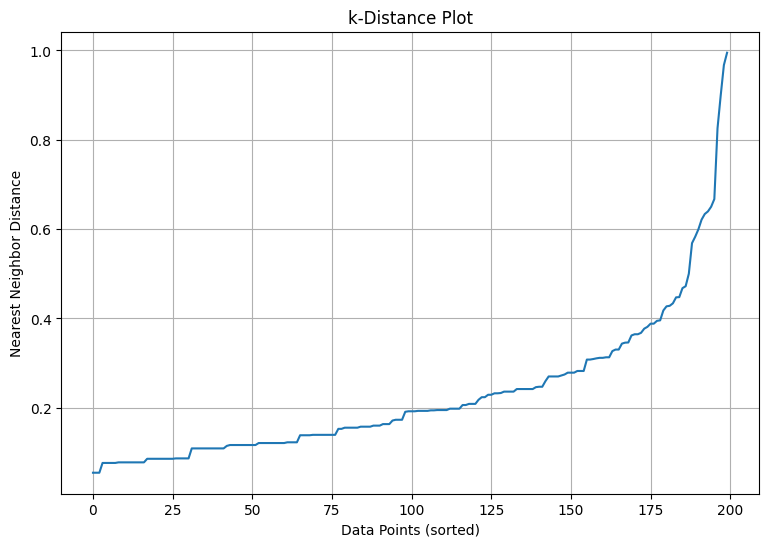

In [34]:
# In order to determine the optimal eps (used in the model below), we will apply a k-distance graph
# This plot will show the sorted distances of each data point to its k-th nearest neighbor (where k = min_samples)

# Compute the k-nearest neighbors distances
k = 4  # We will start with a minimum value of 3 because we have 2 features in the data, then we'll try higher values to see how the elbow point changes
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(scaled_data_mall)
distances, indices = nbrs.kneighbors(scaled_data_mall)

# Sort distances for the k-distance plot
distances = np.sort(distances[:, 3])  # Change to match k value -1
plt.figure(figsize=(9, 6))
plt.plot(distances)
plt.title('k-Distance Plot')
plt.xlabel('Data Points (sorted)')
plt.ylabel('Nearest Neighbor Distance')
plt.grid()
plt.show()

In [35]:
# Initialize DBSCAN

dbscan = DBSCAN(eps=0.4, min_samples=3, metric='euclidean')  # Based on elbow point in the plot above, we will use eps=0.4
# eps (Epsilon) determines the neighborhood radius.  All points within this distance are considering part of the neighborhood
# min_samples specifies the minimum points to form a cluster
# euclidean distance is the default and assumed to work well with most datasets

# Fit and predict clusters
cluster_labels_DB = dbscan.fit_predict(scaled_data_mall)

In [36]:
data_mall['DBSCAN_Cluster'] = cluster_labels_DB

In [37]:
# Calculate Silhoutte Score

if len(set(cluster_labels)) > 1:  # Ensure that there is more than one cluster
    silhouette_avg = silhouette_score(scaled_data_mall, cluster_labels_DB)
    print(f"Average Silhouette Score for DBSCAN: {silhouette_avg:.2f}")
else:
    print("DBSCAN found no clusters.")

# Calculate Davies Bouldin Score

db_index_DB = davies_bouldin_score(scaled_data_mall, cluster_labels_DB)
print(f"Davies-Bouldin Index for DBSCAN: {db_index_DB}")

Average Silhouette Score for DBSCAN: 0.36
Davies-Bouldin Index for DBSCAN: 0.7581895372896994


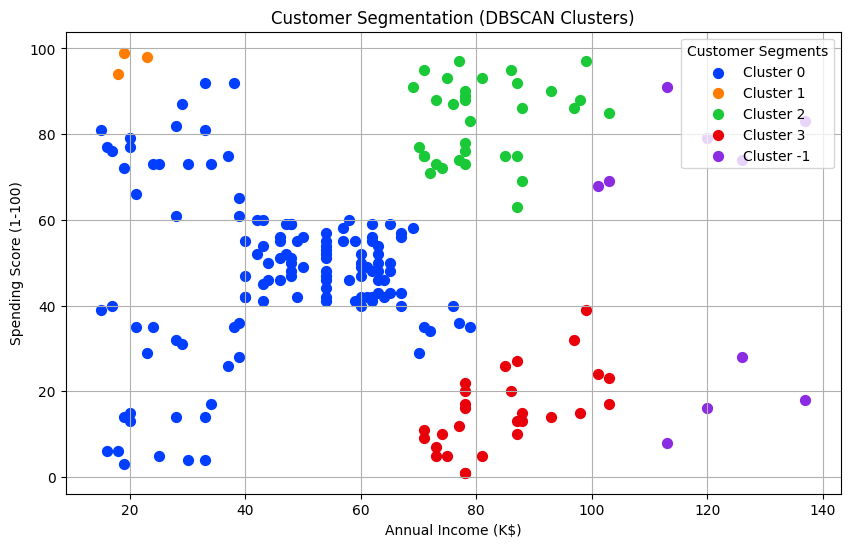

In [38]:
# Define a color palette for clusters
palette = sns.color_palette('bright', n_colors=len(data_mall['DBSCAN_Cluster'].unique()))

# Plot with manual color mapping
plt.figure(figsize=(10, 6))
for i, cluster in enumerate(data_mall['DBSCAN_Cluster'].unique()):
    subset = data_mall[data_mall['DBSCAN_Cluster'] == cluster]
    plt.scatter(subset['Annual Income (k$)'], subset['Spending Score (1-100)'],
                color=palette[i], s=50, label=f'Cluster {cluster}')

# Add legend with labels
plt.legend(title='Customer Segments', loc='upper right')
plt.title('Customer Segmentation (DBSCAN Clusters)')
plt.xlabel('Annual Income (K$)')
plt.ylabel('Spending Score (1-100)')
plt.grid(True)
plt.show()


**Analyze DBSCAN clusters and compare with previous models:**

Based on the above cluster quality metrics and scatter plot for our DBSCAN model, it appears DBSCAN generates lower quality clusters than K-Means and Hierarchical clustering.  The Silhouette Score and Davies-Bouldin Score for our DBSCAN model indicate less desirable segmentation compared to previous models and the DBSCAN scatter plot has a poorly formed cluster (Cluster -1) that is so dispersed that its being classified as noise.

Additionally, Cluster 0 in the DBSCAN plot appear oversized and encompasses both very high-spending customers and very low-spending customers.  Cluster 2 and Cluster 3 are much tighter but Cluster 1 is very small (only 3 customers), which may limit its value in real-world use.

It should be noted that various eps/min_samples values were tried when building the DBSCAN model but none appeared to achieve better cluster quality than the version plotted above.

**Dimensionality Reduction:**

Apply PCA to the data and visualize the results:

In [39]:
from sklearn.decomposition import PCA

In order to increase the value of the PCA, let's add the Age feature back into the data.

In [40]:
# Select relevant features for clustering
selected_features_w_age = data_mall[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']]

# Standardize the data
scaler = StandardScaler()
scaled_data_mall_w_age = scaler.fit_transform(selected_features_w_age)

In [41]:
# Initialize PCA and fit to scaled data
pca = PCA()
pca_data = pca.fit_transform(scaled_data_mall_w_age)

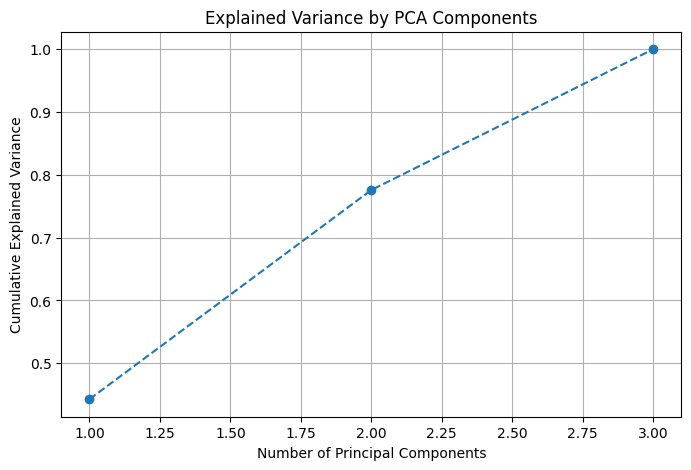

In [42]:
# Cumulative explained variance
explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()


In [43]:
# Retain enough components to explain 95% of the variance
pca = PCA(n_components=0.95)  # Retains 95% of variance
reduced_data = pca.fit_transform(scaled_data_mall_w_age)

print(f"Reduced data shape: {reduced_data.shape}")
print(f"Original data shape: {scaled_data_mall_w_age.shape}")


Reduced data shape: (200, 3)
Original data shape: (200, 3)


We attempted PCA using a data set with 2 features (Income, spending) and 3 features (Age, Income, Spending) but in both cases, the PCA did not reduce the number of dimensions.  This likely occured for two reasons: 1) The three features are uncorrelated or equally important  2)  There are too few features in the data to begin with.

Ideally, dimensionality reduction should improve cluster quality by removing noise and improving computational efficiency.  However, that nature of our customer data does not lend itself to noise, as the clusters in our initial k-means model were well defined with no signficant outliers.  Also, our scatter plots showed little or no relationship between income and spend - there were various spending levels across both income groups, so these features don't appear to correlated.  The fact that our PCA implementation retained all features seems to validate this lack of correlation in the original data.

If our data set had columns like "appraised value of home", "credit score" and "credit card debt", PCA probably would have constructively reduced dimensionality because more correlation would exist between these features.

Additionally, PCA is sometimes used to improve computational performance but there is little room for improvement with our data because the original data set is already quite small.

**Real-world Application Scenario**

Business scenario utilizing the clustered data:

Our K-Means model generated the highest quality clusters, so we'll move forward with implementing this customer segmentation to improve our mobile banking application, called XYZ Banking App

*   When the customer logs-in to the XYZ Banking App, the customer is recognized as belonging to one of the five groups identified above - high-income/high-spend, high-income/low-spend, low-income/high-spend, low-income/low-spend or mid-income/mid-spend.
*   The app loads a specific layout based on the customer characteristics:
*   **High-income/High-spend** will see coupons for restaurants and
shopping, links to vacation and travel offers and ads for our high-limit credit card which offers additional shopping/travel rewards.
*   **High-income/low-spend** will see information on high-yield investment products and other investment opportunities like private equity funds, bond funds and target-date funds.  This group will also see credit card offers focused more on low APR and cash back rewards.
*  **Low-income/high-spend** customers will see ads for a savings account (if they don't already have one) with the intention of adding this product and improving their financial wellbeing.  They will also see competitive shopping and travel offers that may fit their budget better than the more expensive offers displayed for the high income/high spend group.
*   **Low-income/low-spend** customers will see low-APR, low-limit credit card ads and also savings and investment products that are more suited towards lower income customers in addition to information on growing savings and improving one's credit score.
*  **Mid-income/mid-spend** will be shown a blend of the above offers, perhaps randomly displayed to test interest across products/offers targeting different income/spend groups

We will then measure performance based on various criteria including new accounts growth versus the previous version of our app.

Our segmentation and dimensionality techniques (if applicable) will provide various strategic insights including how effectively certain offers for credit cards are targeting their intended target market.  By effectively segmenting our customers, we may also discover previously unknown customer behaviors - for example, we may find that low-income/high-spend customers are much more likely to open a new savings account than previously expected.

Additionally, as our customer data scales, PCA will likely become more valuable particularly if more customer characteristics are added.